6/7/18

In this notebook I attempt to apply block centroid allocation to convert data aggregated by DOGAMI Neighborhood Unit to the larger neighborhoods defined by the Disaster Resilience Team. I leverage DB data wrangling functions written by Fred Pearce (https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks/block_centroid_allocation_dogami_to_disaster.ipynb) to access the DOGAMI data and then use geopandas for spatial operations.

In [1]:
# Jupyter notebook for analyzing DOGAMI data, see Scott Tse's emergence-response notebook at
# https://github.com/hackoregon/emergency-response/blob/analytics/notebooks/census_eda_geo.ipynb
# See block centroid allocation method described here: 
# https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks/block_centroid_allocation.ipynb
# NOTE: Don't need all of these!
# Import modules included in "kitchen-sink"
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import gdal
from osgeo import osr, ogr
import pandas as pd
import psycopg2
from pyproj import Geod
import seaborn as sns
from shapely.geometry import Polygon
import sys
# Import modules NOT included in "kitchen-sink", not sure about osgeo...
from dotenv import load_dotenv, find_dotenv # install python-dotenv
import geoplot as gplt   # requires cython
import geoplot.crs as gcrs
%matplotlib inline

In [2]:
# Define ALL parameters in dictionary (convert to json config file!)
params = {
    'geometry_in': {
        'from_postgis': {
            # You MUST have a .env file specifying parameters for postgis db in order to
            # read data in from postgis! See sample_env.txt at 
            # https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks
            'query': {
                'string': '''
                    SELECT nu.nuid,
                        nu.county AS county,
                        nu.acres AS acres,
                        nu.bldgcount AS buildingcount,
                        nu.bldgsqft AS buildingsquarefeet,
                        nu.bldgcost AS buildingcost,
                        nu.bldgweight AS buildingweight,
                        nu.contentcost AS contentcost,
                        nu.permresidents AS permanentresidents,
                        nu.dayoccupants AS dayoccupants,
                        nu.nightoccupants AS nightoccupants,
                        ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
                        lnuw.bldgloss AS buildingloss_wet, 
                        lnuw.bldg_lr AS buildingloss_ratio_wet,
                        lnuw.contentloss AS contentloss_wet,
                        lnuw.debris AS debris_wet,
                        lnuw.displacedpop AS displacedpopulation_wet,
                        lnuw.pdsnone AS buildings_nodamage_wet,
                        lnuw.pdsslight AS buildings_slightdamage_wet,
                        lnuw.pdsmoderate AS buildings_moderatedamage_wet,
                        lnuw.pdsextensive AS buildings_extensivedamage_wet,
                        lnuw.pdscomplete AS buildings_completedamage_wet,
                        lnuw.casdaytotal AS casualtiestotal_day_wet,
                        lnuw.casdayl1 AS casualtieslevel1_day_wet,
                        lnuw.casdayl2 AS casualtieslevel2_day_wet,
                        lnuw.casdayl3 AS casualtieslevel1_day_wet,
                        lnuw.casdayl4 AS casualtieslevel2_day_wet,
                        lnuw.casnighttotal AS casualtiestotal_night_wet,
                        lnuw.casnightl1 AS casualtieslevel1_night_wet,
                        lnuw.casnightl2 AS casualtieslevel2_night_wet,
                        lnuw.casnightl3 AS casualtieslevel1_night_wet,
                        lnuw.casnightl4 AS casualtieslevel2_night_wet,
                        lnud.bldgloss AS buildingloss_dry, 
                        lnud.bldg_lr AS buildingloss_ratio_dry,
                        lnud.contentloss AS contentloss_dry,
                        lnud.debris AS debris_dry,
                        lnud.displacedpop AS displacedpopulation_dry,
                        lnud.pdsnone AS buildings_nodamage_dry,
                        lnud.pdsslight AS buildings_slightdamage_dry,
                        lnud.pdsmoderate AS buildings_moderatedamage_dry,
                        lnud.pdsextensive AS buildings_extensivedamage_dry,
                        lnud.pdscomplete AS buildings_completedamage_dry,
                        lnud.casdaytotal AS casualtiestotal_day_dry,
                        lnud.casdayl1 AS casualtieslevel1_day_dry,
                        lnud.casdayl2 AS casualtieslevel2_day_dry,
                        lnud.casdayl3 AS casualtieslevel1_day_dry,
                        lnud.casdayl4 AS casualtieslevel2_day_dry,
                        lnud.casnighttotal AS casualtiestotal_night_dry,
                        lnud.casnightl1 AS casualtieslevel1_night_dry,
                        lnud.casnightl2 AS casualtieslevel2_night_dry,
                        lnud.casnightl3 AS casualtieslevel1_night_dry,
                        lnud.casnightl4 AS casualtieslevel2_night_dry
                    FROM neighborhood_units nu
                    INNER JOIN loss_neighborhood_unit_csz_m9p0_dry lnud
                    ON nu.nuid = lnud.nuid
                    INNER JOIN loss_neighborhood_unit_csz_m9p0_wet lnuw
                    ON nu.nuid = lnuw.nuid
                    ''',
                'epsg_code': 4326
                #'table_name': ['neighborhood_units', 'loss_neighborhood_unit_csz_m9p0_dry',
                #              'loss_neighborhood_unit_csz_m9p0_wet'],
                #'select_cols': 'nuid',
                #'geometry_col': 'wkb_geometry',
                #'epsg_code': 4326
            }
        }
    },
    'geometry_out': {
        'from_file': {
            'name':'./Data/DisasterNeighborhoods_FIXED_final/RLIS_ST_clips_pdx_jurisa_FIXED.dbf',
            'geom_col': 'geometry'
        },
    },
    'write_csv': {
        'name': "./bca_test_results.csv"
        #'name': "./DOGAMI_neighborhoodunits_raster_stats_v3.csv"
    }
}

In [3]:
print(params['geometry_in']['from_postgis']['query']['epsg_code'])   

4326


In [4]:
# Functions for obtaining geopandas dataframe containing geometry column from either
# 1) a local file (e.g. .dba file) or 2) interacting with PostGres database
def pgconnect():
    """Establish connection to PostGres database using the parameters specified in .env file.
    First, walk root diretory to find and load .env file w/ PostGres variables defining database, 
    user, host, password, and port variables.
    Then, return connection to database from psycopg2.connect
    """
    try:
        load_dotenv(find_dotenv())
        conn = psycopg2.connect(database=os.environ.get("PG_DATABASE"), user=os.environ.get("PG_USER"), 
                            password = os.environ.get("PG_PASSWORD"), 
                            host=os.environ.get("PG_HOST"), port=os.environ.get("PG_PORT"))
        print("Opened database successfully\n")
        return conn
    except psycopg2.Error as e:
        print("Unable to connect to the database\n")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        #print(traceback.format_exc())
        return None

def get_query_string(table_name, select_cols, geometry_col, epsg_code):
    """Build query string from parameter inputs defining table name, all the columns
    to select, select_cols, the column that defines the geometry, geometry_col, and
    the epsg code that defines the ellipsoid.
    """
    query_string = 'SELECT ' + select_cols + ', ' + \
            'ST_TRANSFORM({}, {}) AS geometry'.format(geometry_col, epsg_code)
    return query_string + ' FROM {}'.format(table_name)
    
    
def get_geometry_from_postgis(postgis_params):
    '''
    This function takes a dictionary containing parameters for building a SQL query,
    as defined in get_query_string, then connects to a postgis db, selects the 
    data specified in the query, and finally returns a geodataframe with a single
    column named geometry that contains shape data.
    '''
    #query_string = get_query_string(**postgis_params['query'])
    query_string = postgis_params['query']['string']
    conn = pgconnect()
    #cur = conn.cursor()
    print("SQL QUERY = "+query_string+'\r\n')
    try:
        geo_df = gpd.GeoDataFrame.from_postgis(
            query_string, 
            conn, 
            geom_col='geometry', 
            crs={'init': u'epsg:{}'.format(postgis_params['query']['epsg_code'])}, 
            coerce_float=False
        )
        return geo_df
    except Exception as e:
        print(e)
    finally:
        conn.close()
        
def get_geometry_from_file(name, geom_col='geometry'):
    """Import geometry from a file using geopandas.read_file
    Returns only the geometry column!
    """
    gdf = gpd.read_file(name)
    #print(type(gdf))
    return gdf

def calc_square_lonlat(lon_lat, xy_offset):
    """Calculate the longitude and latitude corresponding to the upper-right and lower-left
    corners of a square box centered on lat_lon, with a width of 2*xy_offset. 
    xy_offset MUST be in meters. Uses WGS84 (epsg=4326) ellipsoid.
    """
    az = [45, 225]
    lon = 2*[lon_lat[0]]
    lat = 2*[lon_lat[1]]
    mag = 2*[np.sqrt(2)*xy_offset]
    g = Geod(ellps='WGS84')
    rl_lon, tb_lat, _ = g.fwd(lon, lat, az, mag)
    return (rl_lon, tb_lat)

def calc_square_polygon(lon_lat, xy_offset):
    """Calculate polygon defining square box centered on lon, lat (decimal degrees)
    with a width of 2*xy_offset (meters).
    """
    rl_lon, tb_lat = calc_square_lonlat(lon_lat, xy_offset)
    poly = [Polygon((
            (rl_lon[0], tb_lat[0]),
            (rl_lon[0], tb_lat[1]),
            (rl_lon[1], tb_lat[1]),
            (rl_lon[1], tb_lat[0])
    ))]
    return poly

def get_geometry_from_point(lon_lat, xy_offset, xy_units="m"):
    """Returns a geodataframe containing a single geometry column that
    defines a square box centered on a point, specified as a lat, lon pair,
    The input parameter xy_offset defines the box half-width 
    1) Calculate the top-right corner and bottom-left corner of square box
    centered on lon_lat, using the WGS84 ellipsoid.
    2) Use the lon, lat of each corner to build a rectangular 
    polygon using shapely Polygon.
    3) Convert polygon to pandas geodataframe, set coordinate reference to 
    epsg 4326 (equivalent to WGS84).
    """
    if xy_units == "m":
        poly = calc_square_polygon(lon_lat, xy_offset)
        # Build geodataframe with one row, column
        gdf = gpd.GeoDataFrame(poly, columns=['geometry'], geometry='geometry')
        gdf.crs = {'init' :'epsg:4326'}
        return gdf
    else:
        print("Error: input xy_offset MUST be in meters!!!")

def get_geodf_geometry(**kwargs):
    """Import geometry either from point and size, a file, or from postgis db
    """
    if 'from_point' in kwargs:
        return get_geometry_from_point(**kwargs['from_point'])
    elif 'from_file' in kwargs:
        return get_geometry_from_file(**kwargs['from_file'])
    elif 'from_postgis' in kwargs:
        return get_geometry_from_postgis(kwargs['from_postgis'])

In [5]:
# Step 1) Select geodataframe from Postgis db. Make sure geometry
# has a valid epsg Spatial reference assigned to it, such as 4326 (lon/lat)
# For a Postgis-derived geometry, this is done on the db-side using ST_TRANSFORM
# Note a copy of the original geopandas dataframe is made to preserve the dataframe
# obtained from postgis for debugging :-)
loss_gdf = get_geodf_geometry(**params['geometry_in'])
loss_gdf.info()
print(loss_gdf.geometry.crs)
print(loss_gdf.geometry)

Opened database successfully

SQL QUERY = 
                    SELECT nu.nuid,
                        nu.county AS county,
                        nu.acres AS acres,
                        nu.bldgcount AS buildingcount,
                        nu.bldgsqft AS buildingsquarefeet,
                        nu.bldgcost AS buildingcost,
                        nu.bldgweight AS buildingweight,
                        nu.contentcost AS contentcost,
                        nu.permresidents AS permanentresidents,
                        nu.dayoccupants AS dayoccupants,
                        nu.nightoccupants AS nightoccupants,
                        ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
                        lnuw.bldgloss AS buildingloss_wet, 
                        lnuw.bldg_lr AS buildingloss_ratio_wet,
                        lnuw.contentloss AS contentloss_wet,
                        lnuw.debris AS debris_wet,
                        lnuw.displacedpop AS displacedpopulatio

In [6]:
# get the census blocks
or_blocks = gpd.read_file("../data/census_blocks_2010/tabblock2010_41_pophu/tabblock2010_41_pophu.shp")

In [7]:
or_blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry
0,41,001,950100,1377,410019501001377,N,0,0,"POLYGON ((-118.383665 44.690009, -118.383829 4..."
1,41,001,950100,1309,410019501001309,N,0,0,"POLYGON ((-118.39982 44.657918, -118.399959 44..."
2,41,001,950100,1946,410019501001946,N,0,0,"POLYGON ((-118.405203 44.641425, -118.405266 4..."
3,41,001,950100,1340,410019501001340,N,2,0,"POLYGON ((-118.478474 44.67859199999999, -118...."
4,41,001,950100,1402,410019501001402,N,0,0,"POLYGON ((-118.430122 44.693929, -118.43011 44..."


In [8]:
or_blocks.crs

{'init': 'epsg:4269'}

In [9]:
# align block crs to NUs
or_blocks = or_blocks.to_crs({'init': 'epsg:4326'})

In [10]:
# spatial join census blocks to DOGAMI neighborhood units based on which blocks are within which NUs

block_loss = gpd.sjoin(or_blocks, loss_gdf, op='within')

In [11]:
block_loss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 23914 entries, 7944 to 190061
Data columns (total 61 columns):
STATEFP10                        23914 non-null object
COUNTYFP10                       23914 non-null object
TRACTCE10                        23914 non-null object
BLOCKCE                          23914 non-null object
BLOCKID10                        23914 non-null object
PARTFLG                          23914 non-null object
HOUSING10                        23914 non-null int64
POP10                            23914 non-null int64
geometry                         23914 non-null object
index_right                      23914 non-null int64
nuid                             23914 non-null int64
county                           23914 non-null object
acres                            23914 non-null float64
buildingcount                    23914 non-null int64
buildingsquarefeet               23914 non-null int64
buildingcost                     23914 non-null float64
bui

In [12]:
# sum up population and housing units by NU
nu_populations = block_loss[['nuid', 'POP10', 'HOUSING10']].groupby('nuid').sum().reset_index()
nu_populations.rename(columns={'POP10':'Total_Population', 'HOUSING10':'Total_Housing_Units'}, inplace=True)

In [13]:
nu_populations.head()

,nuid,Total_Population,Total_Housing_Units
0,1,1433,572
1,2,673,315
2,3,399,249
3,4,226,102
4,5,361,136


In [14]:
# merge the totals back onto block_loss in order to calculate population weighting of each block to NU
block_loss = block_loss.merge(nu_populations, on='nuid', how='inner')
block_loss['pop_weight'] = block_loss['POP10']/block_loss['Total_Population']
block_loss.head(3)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,index_right,...,casualtieslevel1_day_dry,casualtieslevel2_day_dry,casualtiestotal_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,Total_Population,Total_Housing_Units,pop_weight
0,41,005,024400,1001,410050244001001,N,440,926,"POLYGON ((-122.757593 45.33192500000001, -122....",224,...,1.43718,2.78204,8.00301,6.45808,1.18965,0.121139,0.234145,3593,1492,0.257723
1,41,005,024400,1003,410050244001003,N,12,25,"POLYGON ((-122.757139 45.322438, -122.757365 4...",224,...,1.43718,2.78204,8.00301,6.45808,1.18965,0.121139,0.234145,3593,1492,0.006958
2,41,005,024400,1030,410050244001030,N,85,217,"POLYGON ((-122.752744 45.305436, -122.752918 4...",224,...,1.43718,2.78204,8.00301,6.45808,1.18965,0.121139,0.234145,3593,1492,0.060395


We can then take any NU unit value that can be summed and then calculate its population weighted value for a census block. We can then calculate the centroid of each block and do a spatial join of those centroids to the Disaster Team Neighborhoods (DN) to determine which DN to allocate those values to.

In [15]:
block_loss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 23914 entries, 0 to 23913
Data columns (total 64 columns):
STATEFP10                        23914 non-null object
COUNTYFP10                       23914 non-null object
TRACTCE10                        23914 non-null object
BLOCKCE                          23914 non-null object
BLOCKID10                        23914 non-null object
PARTFLG                          23914 non-null object
HOUSING10                        23914 non-null int64
POP10                            23914 non-null int64
geometry                         23914 non-null object
index_right                      23914 non-null int64
nuid                             23914 non-null int64
county                           23914 non-null object
acres                            23914 non-null float64
buildingcount                    23914 non-null int64
buildingsquarefeet               23914 non-null int64
buildingcost                     23914 non-null float64
buildin

In [16]:
block_loss.crs

{'init': 'epsg:4326'}

In [17]:
# Step 2) Load the neighborhood geometry shapefile
disneigh_gdf = get_geodf_geometry(**params['geometry_out'])
# Remove columns that aren't required
disneigh_gdf = disneigh_gdf.drop(columns=['fid_1', 'area', 'sqmile', 'Area_Recal', 'Perim', 'Isop'])
# Make copy for block centroid allocation
all_gdf = disneigh_gdf.copy()
all_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
name        102 non-null object
geometry    102 non-null object
dtypes: object(2)
memory usage: 1.7+ KB


In [18]:
# Step 3) Spatial join disaster neighborhoods with centroids of census block loss data

total_bounds = disneigh_gdf['geometry'].total_bounds
print(total_bounds)
print((total_bounds[2]-total_bounds[0])/100*110*1e3)
print((total_bounds[3]-total_bounds[1])/100*110*1e3)

# Create new loss dataframe with center of census blocks as geometry
block_loss['block_center_gpd'] = block_loss['geometry'].centroid
block_loss = block_loss.set_geometry('block_center_gpd')

[-122.83674938   45.43254202 -122.47203811   45.65287733]
401.18240035073853
242.3688395522511


In [19]:
print(block_loss.geometry.head())

0    POINT (-122.7558757651772 45.32648881681531)
1    POINT (-122.7574506247184 45.32329858659743)
2     POINT (-122.7523824666658 45.3060606114644)
3    POINT (-122.7501397000983 45.30750952996816)
4    POINT (-122.7499780146357 45.30786389793359)
Name: block_center_gpd, dtype: object


In [20]:
# Perform spatial join to assign disaster neighborhood (DN) to each census block,
# based on which DN the centroid of the census block falls within

# drop index created from previous spatial join
# see https://gis.stackexchange.com/questions/265864/multiple-spatial-joins-with-geopandas-in-python

block_loss.drop('index_left', axis=1, inplace=True)
block_loss.drop('index_right', axis=1, inplace=True)

# now spatial join
final = gpd.sjoin(block_loss, disneigh_gdf, how='inner', op='intersects')
final.info()
#print(final.name.sort_values())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9694 entries, 114 to 18080
Data columns (total 66 columns):
STATEFP10                        9694 non-null object
COUNTYFP10                       9694 non-null object
TRACTCE10                        9694 non-null object
BLOCKCE                          9694 non-null object
BLOCKID10                        9694 non-null object
PARTFLG                          9694 non-null object
HOUSING10                        9694 non-null int64
POP10                            9694 non-null int64
geometry                         9694 non-null object
nuid                             9694 non-null int64
county                           9694 non-null object
acres                            9694 non-null float64
buildingcount                    9694 non-null int64
buildingsquarefeet               9694 non-null int64
buildingcost                     9694 non-null float64
buildingweight                   9694 non-null int64
contentcost           

In [21]:
final.tail()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,nuid,...,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,Total_Population,Total_Housing_Units,pop_weight,block_center_gpd,index_right,name
18073,41,051,009301,3007,410510093013007,N,26,73,"POLYGON ((-122.50364 45.522246, -122.503688 45...",542,...,1.927,0.234068,0.012154,0.023111,2877,1087,0.025374,POINT (-122.5042712031598 45.52070469325664),31,GLENFAIR
18074,41,051,009301,2014,410510093012014,N,53,168,"POLYGON ((-122.499009 45.522322, -122.499512 4...",542,...,1.927,0.234068,0.012154,0.023111,2877,1087,0.058394,POINT (-122.50026171981 45.52382148755498),31,GLENFAIR
18075,41,051,009301,3005,410510093013005,N,69,204,"POLYGON ((-122.503007 45.519157, -122.503688 4...",542,...,1.927,0.234068,0.012154,0.023111,2877,1087,0.070907,POINT (-122.502763130276 45.52063956467775),31,GLENFAIR
18079,41,051,009301,3006,410510093013006,N,11,33,"POLYGON ((-122.501594 45.521414, -122.501618 4...",542,...,1.927,0.234068,0.012154,0.023111,2877,1087,0.011470,POINT (-122.5021043048276 45.52083354263563),31,GLENFAIR
18080,41,051,009301,3004,410510093013004,N,0,0,"POLYGON ((-122.501577 45.522296, -122.500888 4...",542,...,1.927,0.234068,0.012154,0.023111,2877,1087,0.000000,POINT (-122.5014075950998 45.52222203029233),31,GLENFAIR


In [22]:
nu_loss_final = final[final.columns[11:-4]].multiply(final['pop_weight'], axis="index")

In [23]:
#https://stackoverflow.com/questions/46778392/how-to-multiply-multiple-columns-by-another-column-pandas
#df.update(df.iloc[:, 3:7].mul(df.Count, 0))

# nu_loss_final2 = final.update(final.iloc[:, 11:-4].mul(final.pop_weight, 0))



In [24]:
nu_loss_final.head()

,acres,buildingcount,buildingsquarefeet,buildingcost,buildingweight,contentcost,permanentresidents,dayoccupants,nightoccupants,buildingloss_wet,...,casualtieslevel1_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel2_night_dry,casualtieslevel1_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel2_night_dry,Total_Population,Total_Housing_Units
114,7.142292,4.624506,56030.184980,7.799342e+06,3049.214229,7.535684e+06,13.678261,69.449802,15.188933,1.665983e+06,...,0.042868,0.000849,0.009205,0.001571,0.042868,0.000849,0.009205,0.001571,13.0,8.067194
115,3.296443,2.134387,25860.085375,3.599696e+06,1407.329644,3.478008e+06,6.313043,32.053755,7.010277,7.689154e+05,...,0.019785,0.000392,0.004249,0.000725,0.019785,0.000392,0.004249,0.000725,6.0,3.723320
116,6.592885,4.268775,51720.170751,7.199393e+06,2814.659289,6.956016e+06,12.626087,64.107510,14.020553,1.537831e+06,...,0.039571,0.000783,0.008497,0.001450,0.039571,0.000783,0.008497,0.001450,12.0,7.446640
121,3.845850,2.490119,30170.099605,4.199646e+06,1641.884585,4.057676e+06,7.365217,37.396047,8.178656,8.970680e+05,...,0.023083,0.000457,0.004957,0.000846,0.023083,0.000457,0.004957,0.000846,7.0,4.343874
124,9.339921,6.047431,73270.241897,1.019914e+07,3987.433992,9.854356e+06,17.886957,90.818972,19.862451,2.178594e+06,...,0.056058,0.001110,0.012038,0.002054,0.056058,0.001110,0.012038,0.002054,17.0,10.549407


In [25]:
nu_loss_final = pd.concat([final[['name']], nu_loss_final], axis=1)

In [42]:
nu_loss_final.head(5)

,name,acres,buildingcount,buildingsquarefeet,buildingcost,buildingweight,contentcost,permanentresidents,dayoccupants,nightoccupants,...,casualtieslevel1_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel2_night_dry,casualtieslevel1_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel2_night_dry,Total_Population,Total_Housing_Units
114,SELLWOOD-MORELAND IMPROVEMENT LEAGUE,7.142292,4.624506,56030.184980,7.799342e+06,3049.214229,7.535684e+06,13.678261,69.449802,15.188933,...,0.042868,0.000849,0.009205,0.001571,0.042868,0.000849,0.009205,0.001571,13.0,8.067194
115,SELLWOOD-MORELAND IMPROVEMENT LEAGUE,3.296443,2.134387,25860.085375,3.599696e+06,1407.329644,3.478008e+06,6.313043,32.053755,7.010277,...,0.019785,0.000392,0.004249,0.000725,0.019785,0.000392,0.004249,0.000725,6.0,3.723320
116,SELLWOOD-MORELAND IMPROVEMENT LEAGUE,6.592885,4.268775,51720.170751,7.199393e+06,2814.659289,6.956016e+06,12.626087,64.107510,14.020553,...,0.039571,0.000783,0.008497,0.001450,0.039571,0.000783,0.008497,0.001450,12.0,7.446640
121,SELLWOOD-MORELAND IMPROVEMENT LEAGUE,3.845850,2.490119,30170.099605,4.199646e+06,1641.884585,4.057676e+06,7.365217,37.396047,8.178656,...,0.023083,0.000457,0.004957,0.000846,0.023083,0.000457,0.004957,0.000846,7.0,4.343874
124,SELLWOOD-MORELAND IMPROVEMENT LEAGUE,9.339921,6.047431,73270.241897,1.019914e+07,3987.433992,9.854356e+06,17.886957,90.818972,19.862451,...,0.056058,0.001110,0.012038,0.002054,0.056058,0.001110,0.012038,0.002054,17.0,10.549407


In [27]:
# sum each column by neighborhood

rollup = nu_loss_final.groupby('name').sum().reset_index()

In [28]:
rollup.head(25)

,name,acres,buildingcount,buildingsquarefeet,buildingcost,buildingweight,contentcost,permanentresidents,dayoccupants,nightoccupants,...,casualtieslevel1_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel2_night_dry,casualtieslevel1_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel2_night_dry,Total_Population,Total_Housing_Units
0,ALAMEDA,408.005138,2314.700000,4.973256e+06,6.029454e+08,1.738745e+05,3.197603e+08,5356.342323,2925.098393,5100.370349,...,2.963495,0.022031,0.372566,0.041448,2.963495,0.022031,0.372566,0.041448,2869.0,1127.581662
1,ARBOR LODGE,503.665738,2869.064731,4.300091e+06,5.213546e+08,1.693597e+05,3.059396e+08,5718.980098,2813.064793,5461.165049,...,4.259178,0.056377,0.643706,0.108298,4.259178,0.056377,0.643706,0.108298,3682.0,1648.094384
2,ARDENWALD-JOHNSON CREEK,166.434003,357.905956,8.494938e+05,1.123069e+08,3.466739e+04,8.554848e+07,803.598807,507.310652,782.426557,...,0.835992,0.014061,0.149464,0.026668,0.835992,0.014061,0.149464,0.026668,331.0,142.893708
3,ARGAY,887.847144,1741.901046,5.630738e+06,7.483570e+08,2.500566e+05,4.845104e+08,6031.522928,3858.122285,5974.727273,...,14.884298,0.386240,3.330917,0.744997,14.884298,0.386240,3.330917,0.744997,3316.0,1392.566372
4,ARLINGTON HEIGHTS,474.469222,388.130081,1.444733e+06,2.222488e+08,7.484811e+04,1.402821e+08,1064.585366,1061.416957,1018.643438,...,13.146679,0.503017,3.639710,0.984330,13.146679,0.503017,3.639710,0.984330,682.0,318.425087
5,ARNOLD CREEK,754.586754,987.331748,2.786208e+06,3.713694e+08,1.024936e+05,2.005633e+08,2363.527547,1734.619385,2255.624491,...,2.290009,0.031291,0.399519,0.058222,2.290009,0.031291,0.399519,0.058222,1211.0,518.448210
6,ASHCREEK,795.528310,2219.634428,4.624682e+06,5.722113e+08,1.593649e+05,2.969565e+08,5309.231350,2007.356961,5050.201558,...,4.614220,0.061771,0.738625,0.117829,4.614220,0.061771,0.738625,0.117829,2976.0,1240.597982
7,BEAUMONT-WILSHIRE,433.512276,2554.607927,4.296133e+06,5.210429e+08,1.621319e+05,2.843143e+08,4914.685121,2516.216212,4677.721046,...,2.216308,0.015482,0.265543,0.029093,2.216308,0.015482,0.265543,0.029093,2300.0,1008.716989
8,BOISE,230.642650,1051.048961,3.346393e+06,4.991456e+08,2.051723e+05,3.478682e+08,3141.249882,2626.050470,3034.692776,...,3.132528,0.068005,0.581251,0.133013,3.132528,0.068005,0.581251,0.133013,2304.0,1025.762173
9,BRENTWOOD/ DARLINGTON,1126.497915,5223.308590,7.674061e+06,9.303163e+08,2.975530e+05,5.790888e+08,12766.440367,7336.354462,12191.809008,...,6.655527,0.044547,0.905922,0.077065,6.655527,0.044547,0.905922,0.077065,6467.0,2482.310259


In [29]:
# export to csv

rollup.to_csv("Data/neighborhood_loss.csv")

(45.4, 45.7)

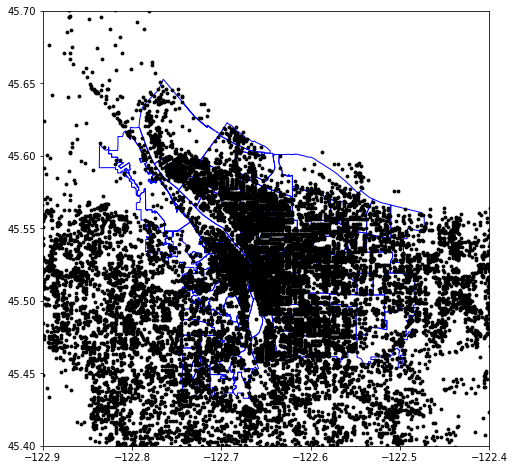

In [31]:
# overlay census blocks on disaster neighborhoods

fig, ax = plt.subplots(1, figsize=(8, 8))
disneigh_gdf.plot(ax=ax, edgecolor='b', linewidth=1, facecolor="None")
block_loss.plot(ax=ax, color='k', markersize=8)
ax.set_xlim([-122.9, -122.4])
ax.set_ylim([45.4, 45.7])

In [32]:
# some summary stats
rollup.describe()

,acres,buildingcount,buildingsquarefeet,buildingcost,buildingweight,contentcost,permanentresidents,dayoccupants,nightoccupants,buildingloss_wet,...,casualtieslevel1_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel2_night_dry,casualtieslevel1_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel2_night_dry,Total_Population,Total_Housing_Units
count,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,947.011425,2055.988795,6.655889e+06,9.517882e+08,3.705137e+05,7.352196e+08,5811.075199,6729.304751,6074.936295,1.869684e+08,...,19.578302,0.608366,4.711310,1.188904,19.578302,0.608366,4.711310,1.188904,3341.840000,1556.277436
std,1093.026755,1707.835840,6.444077e+06,1.045749e+09,5.037656e+05,9.634370e+08,4952.145724,8268.218559,5113.220985,3.553640e+08,...,44.544392,1.560451,11.596733,3.065147,44.544392,1.560451,11.596733,3.065147,2659.606566,1290.350395
min,1.436047,1.078488,3.858051e+03,5.932180e+05,1.848735e+02,4.723023e+05,3.008721,7.870640,2.934593,9.534012e+04,...,0.005377,0.000117,0.001116,0.000225,0.005377,0.000117,0.001116,0.000225,2.000000,0.610465
25%,374.646217,737.137231,3.055800e+06,3.896404e+08,1.269782e+05,2.523639e+08,2340.145660,2120.009775,2456.127723,3.285604e+07,...,3.130805,0.039278,0.450903,0.073730,3.130805,0.039278,0.450903,0.073730,1192.000000,509.704405
50%,571.347345,1836.833972,4.989399e+06,6.692087e+08,2.334447e+05,4.536770e+08,5244.270090,4289.909616,5200.279572,6.439276e+07,...,6.668445,0.112074,1.291477,0.205560,6.668445,0.112074,1.291477,0.205560,2915.500000,1363.639914
75%,1018.339773,2856.371911,8.116607e+06,1.193171e+09,4.480266e+05,9.445152e+08,7609.544175,7789.481978,8041.392117,1.776455e+08,...,14.839520,0.427482,3.408115,0.840484,14.839520,0.427482,3.408115,0.840484,4482.750000,2052.386672
max,6540.009549,7610.858941,4.825722e+07,8.439842e+09,4.237446e+06,7.413253e+09,24089.916890,63325.470922,23987.690152,2.590657e+09,...,395.387725,13.156992,101.185135,25.826620,395.387725,13.156992,101.185135,25.826620,11603.000000,6748.939641


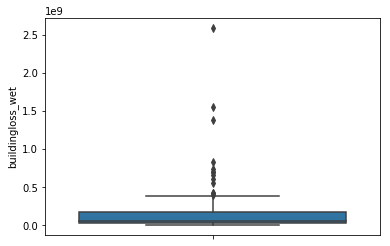

In [33]:
#boxplot of damage by neighborhood

sns.boxplot(y=rollup['buildingloss_wet'])

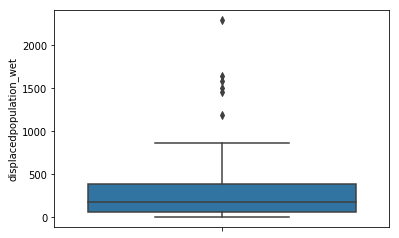

In [34]:
## boxplot of dsiplaced population by neighborhood
sns.boxplot(y=rollup['displacedpopulation_wet'])

In [35]:
# merge neighborhood shapes back onto rollup
rollup = disneigh_gdf.merge(rollup, on='name', how='inner')

In [36]:
rollup.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 69 columns):
name                             100 non-null object
geometry                         100 non-null object
acres                            100 non-null float64
buildingcount                    100 non-null float64
buildingsquarefeet               100 non-null float64
buildingcost                     100 non-null float64
buildingweight                   100 non-null float64
contentcost                      100 non-null float64
permanentresidents               100 non-null float64
dayoccupants                     100 non-null float64
nightoccupants                   100 non-null float64
buildingloss_wet                 100 non-null float64
buildingloss_ratio_wet           100 non-null float64
contentloss_wet                  100 non-null float64
debris_wet                       100 non-null float64
displacedpopulation_wet          100 non-null float64
buildings_nodamage_wet    

Text(0.5,1,'Total Displaced Population by Neighborhood')

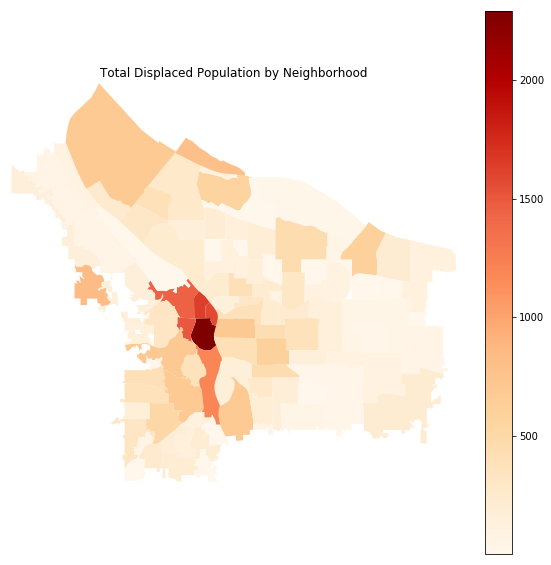

In [37]:
# plot choropleths

gplt.choropleth(rollup,
                hue=rollup['displacedpopulation_wet'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Total Displaced Population by Neighborhood")

May want to redo above choropleth as % if population diplaced by neighborhood

Text(0.5,1,'Total Casualties (Day-Wet Scenario) by Neighborhood')

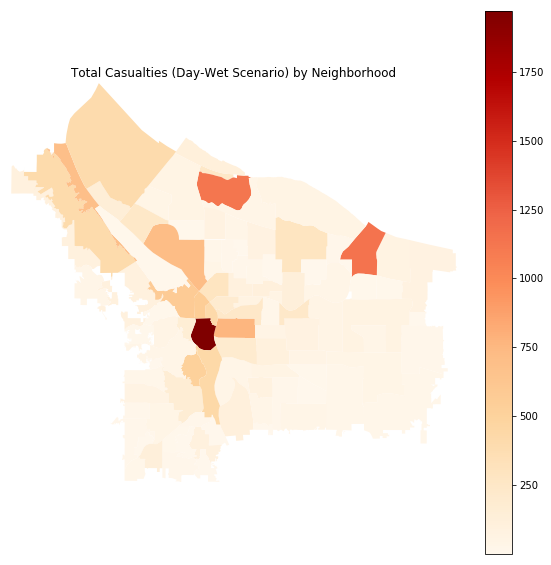

In [38]:
gplt.choropleth(rollup,
                hue=rollup['casualtiestotal_day_wet'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Total Casualties (Day-Wet Scenario) by Neighborhood")


Text(0.5,1,'Total Building Loss (Wet Scenario) by Neighborhood')

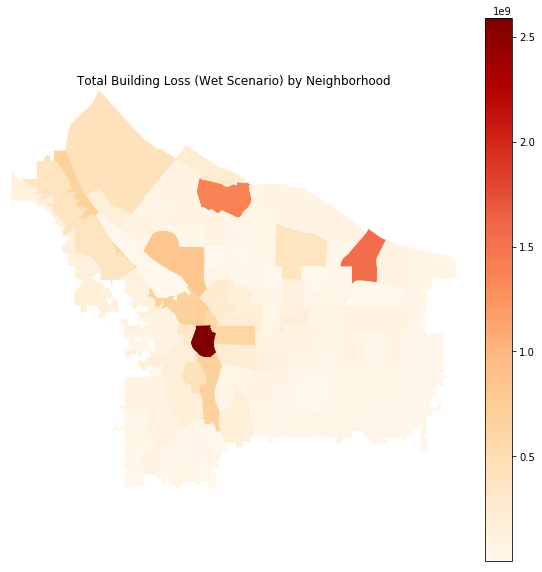

In [39]:
gplt.choropleth(rollup,
                hue=rollup['buildingloss_wet'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Total Building Loss (Wet Scenario) by Neighborhood")


### Testing

### Plotting